In [ ]:
from helper_code import *
from team_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
import numpy as np
from glob import glob
import os
# max_len value sets the max length for every data set
# it will be set to the 90th percentile length in the loop
max_len = 2500 

In [ ]:
directories = glob("data/*/", recursive = True)
directories

- load and pad ecgs and set last value of every lead to the pre-padded lenght of ECG (so last value keeps track of the length of the original ECG, in case we want to do do windowing but dont want to include the 0s)
- dump it all to a big numpy array so they can be easily and efficiently loaded as a memmap array

In [ ]:
directories = glob("data/*/", recursive = True)
path = "data/big_numpy_datasets"
if not os.path.exists(path):
    os.makedirs(path)
    
for d in directories:
    dataset = d.split("/")[-2]+"_signitured"
    print(dataset)
    header_files, recording_files = find_challenge_files(d)
    num_recordings = len(recording_files)
    
    if not num_recordings:
#         raise Exception('No data was provided.')
        continue

    # Extract the classes from the dataset.

    classes = set()
    for header_file in header_files:
        header = load_header(header_file)
        classes |= set(get_labels(header))
    if all(is_integer(x) for x in classes):
        classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
    else:
        classes = sorted(classes) # Sort classes alphanumerically if not numbers.
    num_classes = len(classes)

    # Extract the features and labels from the dataset.
    
    print('Extracting features and labels for %s'%dataset)
    print("\n")
    data = np.zeros((num_recordings, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
    labels = np.zeros((num_recordings, num_classes), dtype=np.bool_) # One-hot encoding of classes
    for i in range(num_recordings):
        print('    {}/{}...'.format(i+1, num_recordings),end="\r")

        # Load header and recording.
        header = load_header(header_files[i])
        recording = load_recording(recording_files[i])


        current_labels = get_labels(header)
        for label in current_labels:
            if label in classes:
                j = classes.index(label)
                labels[i, j] = 1

    df = pd.DataFrame(labels,columns = classes)
    df["headers"] = header_files
    df["leads"] = recording_files
    df.to_csv("data/%s.csv"%dataset,index=False)
    # get the length of the 90th percntile longest ECG
    lengths = [load_recording(rf).shape[-1] for rf in recording_files]
    max_len = int(np.percentile(lengths,90))
    leads_in_memory = []
    i = len(recording_files)
    
    print("remaining files: ")
    for ecg_file in recording_files:
        print(i,end="\r")
        i = i-1
        an_ecg = load_recording(ecg_file)[:,0:max_len] # load ecg
        padded_ecg = np.pad(an_ecg,[[0,0],[0,max_len-an_ecg.shape[-1]]]) # pad ecg to max_len
        padded_ecg[:,-1] = len(an_ecg) # last ecg value = true length of ECG
        leads_in_memory.append(padded_ecg)
    np.save("data/big_numpy_datasets/%s"%dataset,np.stack(leads_in_memory,axis = 0))

In [ ]:
# test loading a dataset
directories = glob("data/*/", recursive = True)
d = directories[0]
dataset = d.split("/")[-2]+"_signitured"
header_files, recording_files = find_challenge_files(d)

# Two ways of visualizing an ecg 

In [11]:
directories = glob("data/*/", recursive = True)

d = directories[0]
dataset = d.split("/")[-2]+"_signitured"
print(dataset)
classes = set()
header_files, recording_files = find_challenge_files(d)
for header_file in header_files:
    header = load_header(header_file)
    classes |= set(get_labels(header))
print(header)

WFDB_CPSC2018_signitured
A6877 12 500 18488 12-May-2020 12:33:59
A6877.mat 16+24 1000/mV 16 0 108 58 0 I
A6877.mat 16+24 1000/mV 16 0 80 16 0 II
A6877.mat 16+24 1000/mV 16 0 -28 -84 0 III
A6877.mat 16+24 1000/mV 16 0 -94 -77 0 aVR
A6877.mat 16+24 1000/mV 16 0 68 19 0 aVL
A6877.mat 16+24 1000/mV 16 0 26 -51 0 aVF
A6877.mat 16+24 1000/mV 16 0 -47 -20 0 V1
A6877.mat 16+24 1000/mV 16 0 200 3 0 V2
A6877.mat 16+24 1000/mV 16 0 124 2 0 V3
A6877.mat 16+24 1000/mV 16 0 78 -50 0 V4
A6877.mat 16+24 1000/mV 16 0 60 2 0 V5
A6877.mat 16+24 1000/mV 16 0 -5 -29 0 V6
#Age: 71
#Sex: Female
#Dx: 164884008
#Rx: Unknown
#Hx: Unknown
#Sx: Unknown



In [14]:
ecg_num = -1
x = load_recording(recording_files[ecg_num])
x = x[:,0:int(max_len)]
x[:,-1] = 100
x

array([[ 108,  160,  143, ...,  114,  127,  100],
       [  80,  118,  105, ...,  130,  141,  100],
       [ -28,  -43,  -38, ...,   16,   14,  100],
       ...,
       [  78,  110,   96, ...,  120,  125,  100],
       [  60,   87,   76, ...,  112,  119,  100],
       [  -5,    9,   23, ..., -823, -821,  100]], dtype=int16)

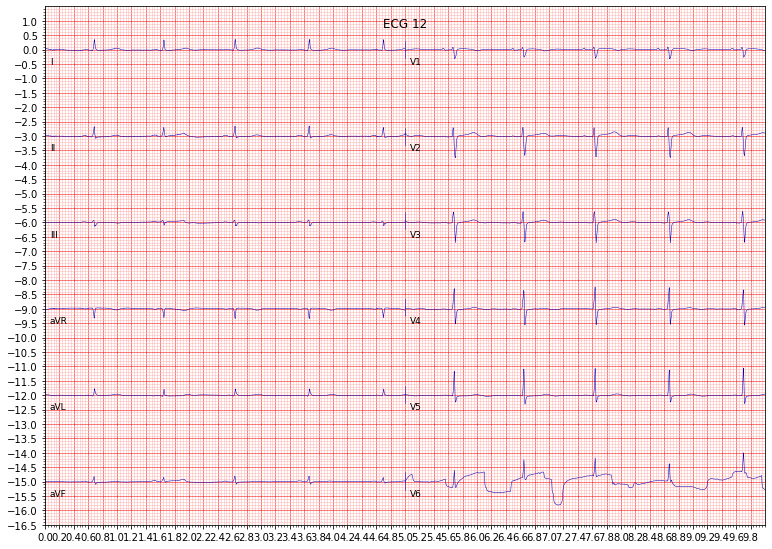

In [16]:

header = load_header(header_files[ecg_num])
leads = load_recording(recording_files[ecg_num])[:,0:2500]
ecg_plot.plot(leads/np.max(leads))

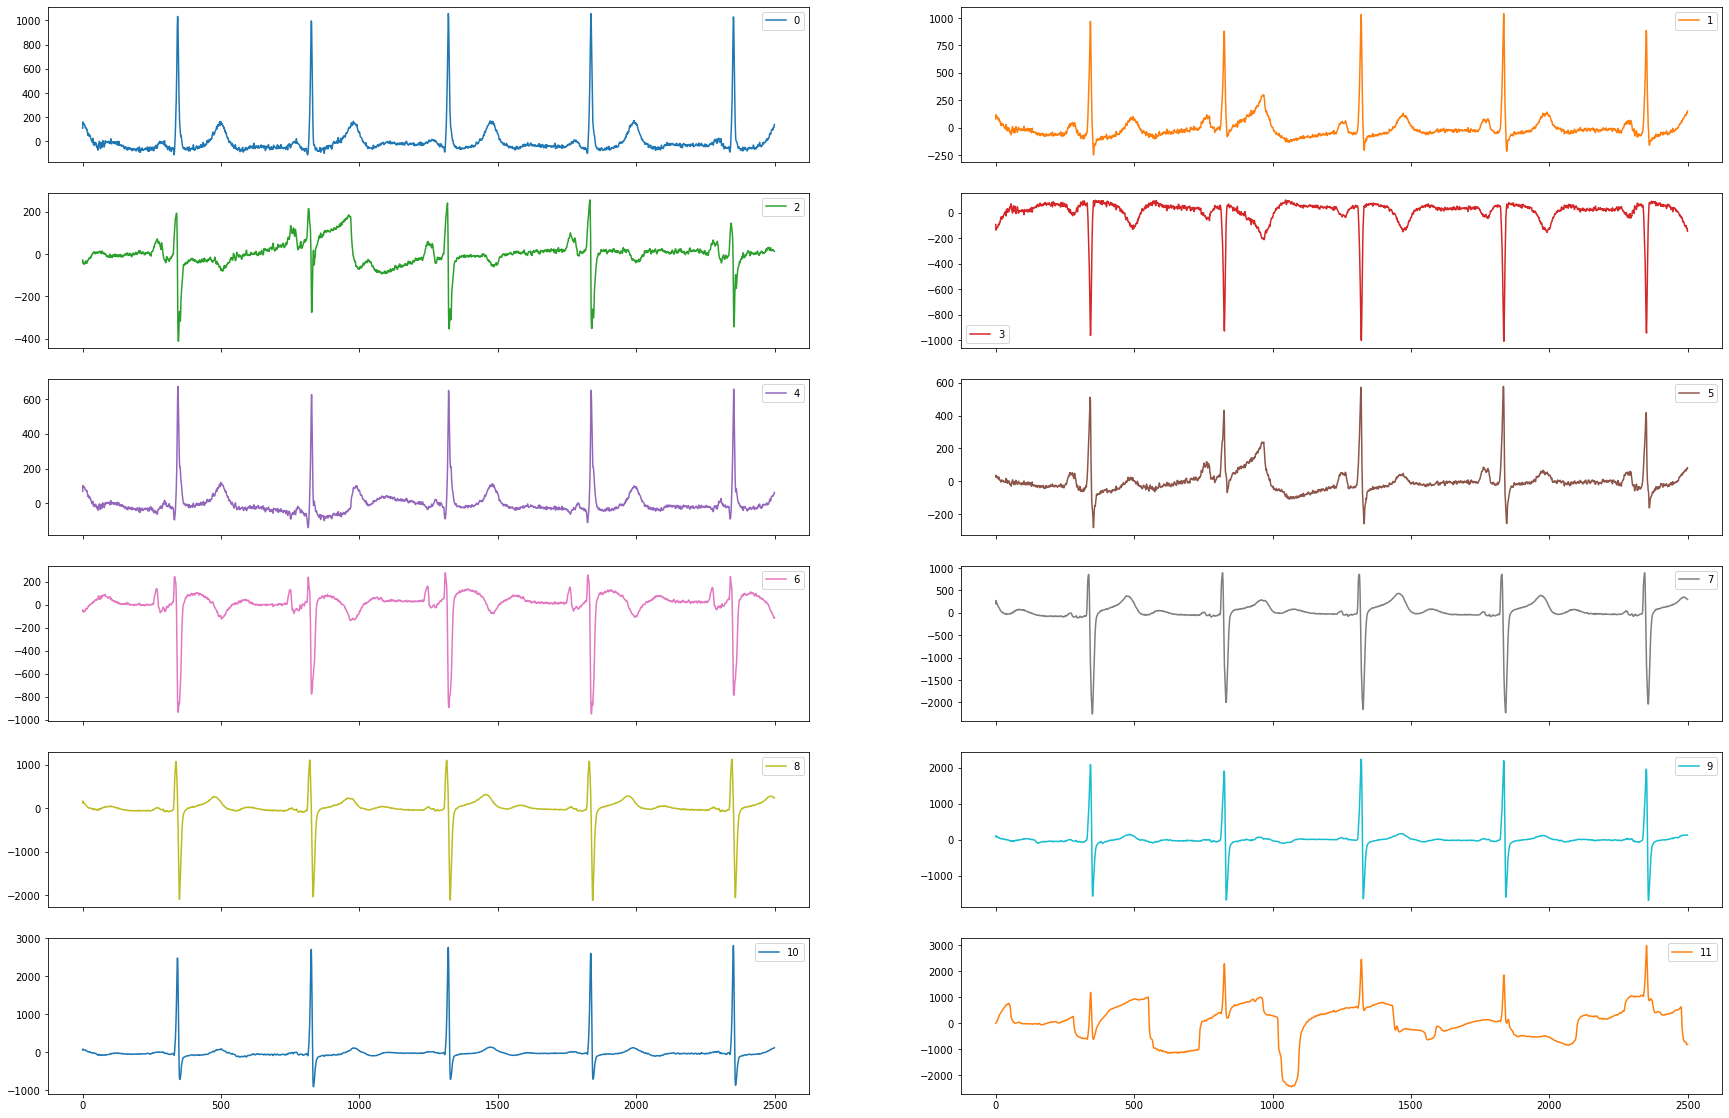

In [17]:
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))